In [3]:
import os
import numpy as np
from tqdm import tqdm
from fastai import *
import torch
from fastai.vision import *
%matplotlib inline
from fastai.callbacks import *
import cv2
import pandas as pd
import splitfolders
import random

In [4]:
image_load_size = 64
bs = 24

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)

In [14]:
splitfolders.ratio('extracted_images', output="final_output_images", seed=SEED, ratio=(.8, .2))

Copying files: 375974 files [04:59, 1256.01 files/s]


In [6]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])

In [7]:
data = (ImageList.from_folder(path='final_output_images')
        .split_by_folder(train='train',valid='val')
        .label_from_folder()
        .transform(tfms,size = image_load_size,resize_method=ResizeMethod.SQUISH)
        .databunch(path='.',bs=bs)    
        .normalize(imagenet_stats)
)

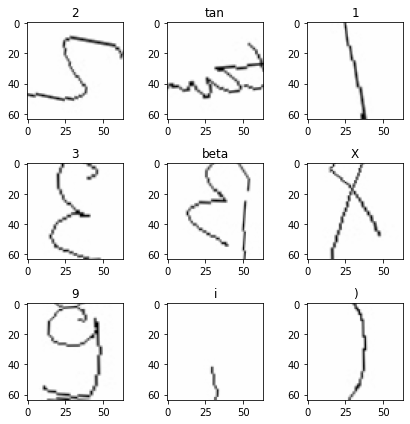

In [6]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [7]:
len(data.classes)

82

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [9]:
model = cnn_learner(data, models.densenet161, metrics = [accuracy,error_rate],callback_fns=[partial(SaveModelCallback, monitor='accuracy', name='best_model')])
model.loss_func = FocalLoss()
model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [96, 32, 32]         14,112     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [96, 16, 16]         0          False     
______________________________________________________________________
BatchNorm2d          [96, 16, 16]         192        True      
______________________________________________________________________
ReLU                 [96, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [192, 16, 16]        18,432     False     
___________________________________________________

In [9]:
lr = 2e-3

In [10]:
#takes 4 hours
#model.fit_one_cycle(5, slice(1e-6,lr/10))

In [10]:
model.load('best_model')

Learner(data=ImageDataBunch;

Train: LabelList (300746 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
beta,beta,beta,beta,beta
Path: final_output_images;

Valid: LabelList (75228 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
beta,beta,beta,beta,beta
Path: final_output_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [13]:
valid_loss_save_model,accuracy_save_model, error_rate_save_model = model.validate(model.data.valid_dl)
print('valid_loss:', valid_loss_save_model, 'accuracy:', float(accuracy_save_model),'error_rate:',float(error_rate_save_model))

valid_loss: 0.052099578 accuracy: 0.9620620012283325 error_rate: 0.03793800249695778


In [12]:
def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(12,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

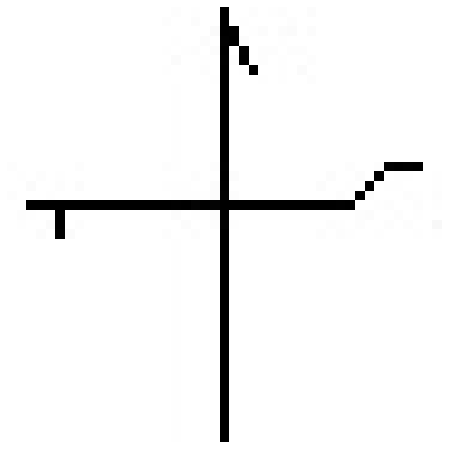

In [13]:
i = cv2.imread('final_output_images/val/+/+_105.jpg')
plot_img(i)

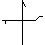

In [17]:
open_image('final_output_images/val/+/+_105.jpg')

In [14]:
pred = model.predict(open_image('final_output_images/val/+/+_105.jpg'))
print(pred[0])

+
